In [38]:
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # use id from $ nvidia-smi

In [18]:
loss = [None]
val_loss = [None]
accuracy = [None]
val_accuracy = [None]
runs = []

In [2]:
df = pd.read_csv('train.csv', sep='\t')
df

,idx,Score,Text
0,0,Positive,В Альфа-Банке работает замечательная девушка -...
1,1,Negative,Оформляя рассрочку в м. Видео в меге тёплый ст...
2,2,Positive,Очень порадовала оперативность работы в банке....
3,3,Negative,Имела неосторожность оформить потреб. кредит в...
4,4,Negative,Небольшая предыстория: Нашел на сайте MDM банк...
...,...,...,...
13994,13994,Positive,"О высокой надёжности МКБ, порядочности и добро..."
13995,13995,Positive,"Обслуживаюсь в офисе на Чернореченской 42а, ка..."
13996,13996,Positive,Попала сегодня в очень неприятную ситуацию. Ре...
13997,13997,Positive,Добрый день! Давно являюсь клиентом банка Русс...


In [25]:
DICTIONARY_SIZE = 50000
MAX_SEQUENCE_LENGTH = 250

tokenizer = Tokenizer(num_words=DICTIONARY_SIZE, filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Text'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 122604 unique tokens.


In [26]:
X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (13999, 250)


In [27]:
classes = pd.get_dummies(df['Score'])
Y = classes.values
cl = list(classes.columns)
print(classes)
print(cl)
print('Shape of label tensor:', Y.shape)

CLASSES_NUM= Y.shape[1]
print('Total classes:', CLASSES_NUM)

       Negative  Positive
0             0         1
1             1         0
2             0         1
3             1         0
4             1         0
...         ...       ...
13994         0         1
13995         0         1
13996         0         1
13997         0         1
13998         1         0

[13999 rows x 2 columns]
['Negative', 'Positive']
Shape of label tensor: (13999, 2)
Total classes: 2


In [28]:
EMBEDDING_DIM = 100

#with strategy.scope():
model = Sequential()
model.add(Embedding(DICTIONARY_SIZE, EMBEDDING_DIM, input_length=X.shape[1]))
#model.add(SpatialDropout1D(0.2))
#model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0))
model.add(Dense(CLASSES_NUM, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
X_train = X
Y_train = Y

In [30]:
epochs = 4
batch_size = 128

#history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/4
110/110 [==============================] - 4s 18ms/step - loss: 0.3619 - accuracy: 0.8295
Epoch 2/4
110/110 [==============================] - 2s 17ms/step - loss: 0.0888 - accuracy: 0.9723
Epoch 3/4
110/110 [==============================] - 2s 17ms/step - loss: 0.0331 - accuracy: 0.9911
Epoch 4/4
110/110 [==============================] - 2s 17ms/step - loss: 0.0163 - accuracy: 0.9962


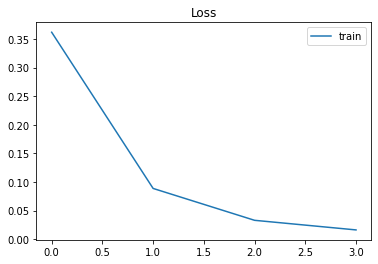

In [31]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

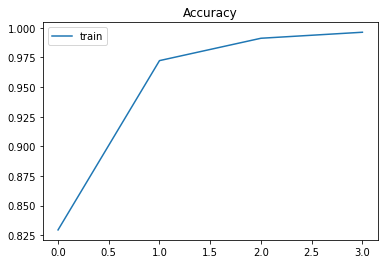

In [32]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [33]:
df_test = pd.read_csv('test.csv', sep='\t')
df_test

,idx,Text
0,13999,Замечательная история об открытии счета в банк...
1,14000,"23.07.14г. я досрочно внес сумму, указанную оп..."
2,14001,Была задолженность по кредитной карте. Банк по...
3,14002,Срочно понадобилась определенная денежная сумм...
4,14003,Здравствуйте. В местном отделении Бинбанка г. ...
...,...,...
5995,19994,Уважаемые представители Русфинанс Банка! Прошу...
5996,19995,04 июня сняли с дебетовой карты банка 10 000 T...
5997,19996,В апреле решил я купить шуруповерт. Посмотрел ...
5998,19997,Недавно взял потребкредит в этом банке. Все че...


In [34]:
X_test = tokenizer.texts_to_sequences(df_test['Text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [35]:
pred = model.predict(X_test)

In [36]:
pred

array([[9.9994552e-01, 5.4501372e-05],
       [9.9984229e-01, 1.5765092e-04],
       [9.9986327e-01, 1.3670108e-04],
       ...,
       [9.9889982e-01, 1.1001528e-03],
       [3.4239920e-04, 9.9965763e-01],
       [6.5042369e-02, 9.3495762e-01]], dtype=float32)

In [45]:
Y_test = []
for i in pred:
    if i[0]>i[1]:
        Y_test.append('Negative')
    else:
        Y_test.append('Positive')
#Y_test = [classes[np.argmax(i)] for i in pred]
#Y_test
#classes[np.argmax(pred)]
Y_test

['Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',

In [50]:
Y_test2 = [cl[np.argmax(i)] for i in pred]
Y_test2

['Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',

In [46]:
df_test2 = df_test
df_test2

,idx,Text
0,13999,Замечательная история об открытии счета в банк...
1,14000,"23.07.14г. я досрочно внес сумму, указанную оп..."
2,14001,Была задолженность по кредитной карте. Банк по...
3,14002,Срочно понадобилась определенная денежная сумм...
4,14003,Здравствуйте. В местном отделении Бинбанка г. ...
...,...,...
5995,19994,Уважаемые представители Русфинанс Банка! Прошу...
5996,19995,04 июня сняли с дебетовой карты банка 10 000 T...
5997,19996,В апреле решил я купить шуруповерт. Посмотрел ...
5998,19997,Недавно взял потребкредит в этом банке. Все че...


In [47]:
df_test2 = df_test
df_test2['Score'] = Y_test
df_test2

,idx,Text,Score
0,13999,Замечательная история об открытии счета в банк...,Negative
1,14000,"23.07.14г. я досрочно внес сумму, указанную оп...",Negative
2,14001,Была задолженность по кредитной карте. Банк по...,Negative
3,14002,Срочно понадобилась определенная денежная сумм...,Negative
4,14003,Здравствуйте. В местном отделении Бинбанка г. ...,Negative
...,...,...,...
5995,19994,Уважаемые представители Русфинанс Банка! Прошу...,Positive
5996,19995,04 июня сняли с дебетовой карты банка 10 000 T...,Positive
5997,19996,В апреле решил я купить шуруповерт. Посмотрел ...,Negative
5998,19997,Недавно взял потребкредит в этом банке. Все че...,Positive


In [48]:
df_test3 = df_test2
del df_test3['Text']
df_test3

,idx,Score
0,13999,Negative
1,14000,Negative
2,14001,Negative
3,14002,Negative
4,14003,Negative
...,...,...
5995,19994,Positive
5996,19995,Positive
5997,19996,Negative
5998,19997,Positive


In [49]:
df_test3.to_csv('submission.csv', sep='\t', index=False)